In [1]:
# v2.0 
# v1.2 수수료 기반 백테스팅 작업, 6시간 수익률 높은 종목 추천, 코드 안정화
# v1.1 확대 축소가 아닌 Low, Upper에 닿을 경우 매수, 매도 결정, 5일 이동평균선 기준
# v1.0 볼린저 밴드 (확대, 축소)를 이용한 알고리즘 매수, 매도 결정

import pandas as pd
import numpy as np
import pyupbit
import datetime
import time
import os

# # min_key numbers
# access_key='WNlqEotmOTIxYKvgtrQupedaIgEnultRrTMeUxAa'
# secret_key='91I4c67FhA88yRLTCuYp7DNphTc0jOEVd0x302R1'

# jiwoo numbers
access_key='RxxAtjdh5TCBv4Wc9ycWKILVBsDhE3ZeiJVXadxF'
secret_key='xavsrBGokR5fqeivyA4ctxFrJgMfjbCCJmxRY5I5'

upbit=pyupbit.Upbit(access_key,secret_key) # upbit 함수 이용하기

# Data 기반 확보
def settings(tickers, intername, cnt, num):
    time2=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:00')
    data = pyupbit.get_ohlcv(tickers, interval=intername, count=num, to=time2)  # intername 만큼 num 개수 추출
    i=1
    while(i<cnt): # 데이터 수 확장하기 (cnt 횟수 만큼)
            date = data.index[0]
            data2 = pyupbit.get_ohlcv(tickers, interval=intername, count=num, to=date)
            data = pd.concat([data,data2], axis=0)  
            data = data.sort_index()
            i+=1
            time.sleep(1)
    return data

# 볼린저밴드 만들기(upper, middle, lower)
def BAND_data(df):
    
    #종가를 이용
    df['line_5']=df['close'].rolling(window=5).mean() # 5일 이동평균선
    df['line_10']=df['close'].rolling(window=10).mean() # 10일 이동평균선
    df['band_mid']=df['close'].rolling(window=20).mean() # 20일 이동평균선
    df['band_up']=df['band_mid']+(df['close'].rolling(window=20).std()*2)  # upper
    df['band_low']=df['band_mid']-(df['close'].rolling(window=20).std()*2)  # lower
    df=df.fillna(0) # 없는 데이터 채우기
    return df

#양봉, 음봉 캔들 생성
def minute_1(temp_df, i):
    blue_b_price=0
    blue_t_price=0
    blue=0
    red_b_price=0
    red_t_price=0
    red=0
    # 일봉 매수, 매도 점 위치 파악 (빨간색, 파란색인지 구별) -> 가격 변수 설정
    chai= (np.round(temp_df.loc[temp_df.index[i],'open'],0) - np.round(temp_df.loc[temp_df.index[i],'close'],0)).astype('float')
    if chai >= 0.0: # 음봉
        blue_b_price=np.round(temp_df.loc[temp_df.index[i],'close'],0)
        blue_t_price=np.round(temp_df.loc[temp_df.index[i],'open'],0)
        blue=1
    else: #양봉
        red_b_price=np.round(temp_df.loc[temp_df.index[i],'open'],0)
        red_t_price=np.round(temp_df.loc[temp_df.index[i],'close'],0)   
        red=1
        
    return blue_b_price, blue_t_price, blue, red_b_price, red_t_price, red

# 볼린저 밴드를 이용한 매수 매도 누적 수익률 test 함수
def band_trainig(temp_df):
    temp_df['B/S']=0  # buy=1, sell=-1
    sign=0  # 매수 or 매도 타이밍
    cnt=0 # 매수 개수
    
    for i in range(1,len(temp_df)):
        mid_price=temp_df.loc[temp_df.index[i],'band_mid']
        upper=temp_df.loc[temp_df.index[i],'band_up']
        lower=temp_df.loc[temp_df.index[i],'band_low']
        line_5=temp_df.loc[temp_df.index[i],'line_5']
        blue=0
        red=0
        
        # 일봉 매수, 매도 점 위치 파악 (빨간색, 파란색인지 구별) -> 가격 변수 설정
        blue_b_price, blue_t_price, blue, red_b_price, red_t_price, red = minute_1(temp_df, i)
            
        if blue==1 and upper<blue_t_price and mid_price<blue_t_price:   #블루봉 사인
            sign=-1 # 매도 타이밍 발생
        elif blue==1 and lower>blue_b_price and mid_price>blue_b_price: 
            sign=1 # 매수 타이밍 발생(1)
        elif red==1 and upper<red_t_price and mid_price<red_t_price:    #레드봉 사인
            sign=-1 # 매도 타이밍 발생(-1)
        elif red==1 and lower>red_b_price and mid_price>red_b_price:
            sign=1 # 매수 타이밍 발생
        
        if sign==-1: # 시그널 지속하며 꺾는점 발생 (진정한 매도 타이밍)
            if blue==1 and blue_t_price<line_5 and mid_price<blue_b_price and cnt>0: # 고점형성 기준 블루봉일시 매도
                temp_df.loc[temp_df.index[i],'B/S']=-1   # 매도한다. 
                cnt=0
                sign=0

            elif red==1 and red_t_price<line_5 and mid_price<red_b_price and cnt>0: # 고점형성 기준 레드봉일시 매도
                temp_df.loc[temp_df.index[i],'B/S']=-1   # 매도한다. 
                cnt=0
                sign=0
                
        elif sign==1: # 시그널 지속하며 꺾는점 발생 (진정한 매수 타이밍)
            if red==1 and mid_price>red_b_price and red_b_price>line_5: # 저점형성 기준 레드봉일시 매수 (레드봉일시만 매수!! (핵심))
                temp_df.loc[temp_df.index[i],'B/S']=1   # 매수한다. 
                cnt+=1
                sign=0
    return temp_df

#누적수익률 계산 함수
def test_rate(temp_df):
    price=0
    cnt=0 # 처음 개수
    sell_rate=[] # 기간별 수익률
    cnt_sum=[]
    total_rate=1
    fee=0.0005  # upbit 수수료 고려
    for i in range(1,len(temp_df)):
        # 일봉 매수, 매도 점 위치 파악 (빨간색, 파란색인지 구별) -> 가격 변수 설정
        blue_b_price, blue_t_price, blue, red_b_price, red_t_price, red = minute_1(temp_df, i)
        
        if temp_df.loc[temp_df.index[i],'B/S']==1 and red==1:   # 매수는 시가로 매수한다. (red일시만 매수)
            price=(price+(red_b_price*(1.0+fee))) # red일 시 아랫 부분
            cnt+=1
        elif temp_df.loc[temp_df.index[i],'B/S']==-1 and cnt>0  and (blue==1 or red==1): # 매도
            if blue==1:  # 블루일시 윗 부분
                sell_p=(blue_t_price*cnt*(1.0-fee))
            elif red==1: # 레드일시 윗 부분
                sell_p=(red_t_price*cnt*(1.0-fee))
            rate=np.round(((sell_p-price)/price),4)
            sell_rate.append(rate)
            cnt_sum.append(cnt)
            price=0
            cnt=0
    # 총 누적수익률
    try:
        for rate in sell_rate:
            total_rate*=(1+rate)
        total_rate-=1
        total_rate=np.round(total_rate*100,5)
        if len(cnt_sum)!=0:
            cnt_max=max(cnt_sum)
        else:
            cnt_max=0
    except:
        cnt_max='error'
        total_rate='error'
    return total_rate, cnt_max

def not_trade(tickers, time2): # 미체결된 주문 취소
    ret=upbit.get_order(tickers, state='wait')
    i=0
    while len(ret)!=0:
        ret=upbit.get_order(tickers)
        uuid=ret.pop(0)['uuid']
        ret2=upbit.cancel_order(uuid)
        print('{0} 미체결된 주문 {2} 중 {1}원이 취소되었습니다.'.format(time2,ret2['price'],tickers[4:]))
        i+=1

def buy_trade(tickers, time2, cnt, buy_cnt): #매수 함수
    try:
        ret=upbit.get_balances()
        check=0
        for name in ret:
            if name['currency']==tickers[4:]:  # 잔고에 있는 매수가 확인
                if float(name['avg_buy_price'])>price:
                    check=0
                else:
                    check=1
        price=pyupbit.get_current_price(tickers)
        if check==1:
            print('잔고에 있는 평균가 {0}원이 주문가격 {1}원보다 낮아 매수 주문이 취소되었습니다.'.format(name['avg_buy_price'],price))
        else: 
            ret = upbit.buy_market_order(tickers, price*buy_cnt) # 시장가 매수를 가격으로 한다.
            cnt+=1
            print('{1} 으로 {2}는 {0}원으로 현재 {4}{3}를 매수 주문 완료했습니다.'.format(price,time2,tickers,tickers[4:],buy_cnt)) 
        return cnt, price
    except:
        print(ret)
        return cnt, price

def sell_trade(tickers, time2, cnt, buy_cnt): #매도 함수   
    try:
        ret=upbit.get_balances()
        for name in ret:
            if name['currency']==tickers[4:]:  # 잔고에 있는 매수평균가 서칭
                avg_buy_price=float(name['avg_buy_price'])
                ret = upbit.sell_market_order(tickers, buy_cnt*cnt)
                price=pyupbit.get_current_price(tickers)
                while True:
                    if len(upbit.get_order(tickers, state='wait'))==0:
                        print('{1} 기준으로 {2}는 {0}원으로 주문({3}) 만큼 매도 완료했습니다.'.format(price,time2,tickers[4:],buy_cnt))
                        avg_price=np.round(((price-avg_buy_price)/avg_buy_price*100),2)
                        print('{0} 수익률은 {1}% 입니다.'.format(time2,avg_price))
                        cnt=0
                        break
        return cnt, price
    except:
        print(ret)
        return cnt, price

# 매수 or 매도 프로그램
def trade(tickers, df, buy_cnt, sign, cnt): # sign=매수 or 매도 타이밍 # band_trainig 에서 결정된 signal 값
    
    #최신데이터 band 형성
    df=BAND_data(df)
    line_5=df.loc[df.index[-1],'line_5']
    line_10=df.loc[df.index[-1],'line_5']
    upper=df.loc[df.index[-1],'band_up']
    lower=df.loc[df.index[-1],'band_low']
    df.loc[df.index[-1],'B/S']=0
    blue=0
    red=0
    
    # 일봉 매수, 매도 점 위치 파악 (빨간색, 파란색인지 구별) -> 가격 변수 설정
    blue_b_price, blue_t_price, blue, red_b_price, red_t_price, red = minute_1(df, -1)
    
    #변수 설정
    price=pyupbit.get_current_price(tickers)  #현재 가격
    time2=df.index[-1]  #시간
    avg_buy_price=0.0
    avg_price=0.0
    
    #band에 따른 매수 or 매도 결정
    mid_price=df.loc[df.index[-1],'band_mid']
    
    # signal 발생
    if blue==1 and upper<blue_t_price and mid_price<blue_t_price:   #블루봉 사인
        sign=-1 # 매도 타이밍 발생
    elif blue==1 and lower>blue_b_price and mid_price>blue_b_price: 
        sign=1 # 매수 타이밍 발생(1)
    elif red==1 and upper<red_t_price and mid_price<red_t_price:    #레드봉 사인
        sign=-1 # 매도 타이밍 발생(-1)
    elif red==1 and lower>red_b_price and mid_price>red_b_price:
        sign=1 # 매수 타이밍 발생
    
    if sign==-1 and cnt>0: # 시그널 지속하며 꺾는점 발생 (진정한 매도 타이밍)
        if blue==1 and blue_t_price<line_5 and mid_price<blue_b_price: # 고점형성 기준 블루봉일시 매도
            df.loc[df.index[-1],'B/S']=-1   # 매도한다. 
            cnt, price = sell_trade(tickers, time2, cnt, buy_cnt) # 시장가 매도
            sign=0

        elif red==1 and red_t_price<line_5 and mid_price<red_b_price: # 고점형성 기준 레드봉일시 매도
            df.loc[df.index[-1],'B/S']=-1   # 매도한다. 
            cnt, price = sell_trade(tickers, time2, cnt, buy_cnt) # 시장가 매도
            sign=0
            
        else:
            print('{1} 기준으로 {2}는 {0}원으로 현재 보류중입니다.(signal 보류 중)'.format(price,time2,tickers))

    elif sign==1: # 시그널 지속하며 꺾는점 발생 (진정한 매수 타이밍)
        if red==1 and mid_price>red_b_price and red_b_price>line_5: # 저점형성 기준 레드봉일시 매수 (레드봉일시만 매수!! (핵심))
            df.loc[df.index[-1],'B/S']=1   # 매수한다. 
            cnt, price = buy_trade(tickers, time2, cnt, buy_cnt)  # 시장가 매수
            sign=0
            
        else:
            print('{1} 기준으로 {2}는 {0}원으로 현재 보류중입니다.(signal 보류 중)'.format(price,time2,tickers))
    
    else:
        print('{1} 기준으로 {2}는 {0}원으로 현재 보류중입니다.'.format(price,time2,tickers))
        
    return sign, cnt, df
        
# 반복 함수 설정
def repeat_module(tickers, band_df, start_rate, buy_cnt):
    sign=0   # band 발생 표시 여부
    cnt=0    # 중복 매수 여부
    while True:
        try:
            time2=datetime.datetime.now()
            if time2.second==1:
                time2=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:00')
                if upbit.get_order(tickers)!='NameError': # 미체결된 주문 취소
                    not_trade(tickers, time2)  
                temp = pyupbit.get_ohlcv(tickers, interval="minute1", count=1, to=time2)
                time.sleep(1)
                band_df=pd.concat([band_df,temp], axis=0)
                band_df.drop([band_df.index[0]], inplace=True)
                sign, cnt, band_df=trade(tickers, band_df, buy_cnt, sign, cnt)
                rate, cnt_max = test_rate(band_df)
                #print("개발자 전용: test= {0}%".format(rate))
                if rate<0:  # 음수일 경우만 수익률 조정
                    print("-----------------Program Pause------------------------")
                    print("   예상수익률 허용범위 벗어나 시스템 재가동 필요      ")
                    print("                                                      ")
                    print("   현재 매수되어 있는 수량: {0}개".format(cnt))
                    print("-----------------Program Pause------------------------")
                    tickers, band_df, start_rate, buy_cnt=slot_setting(0,tickers)

        except KeyboardInterrupt:   # 무한반복 종료
            print("-------------------------Program Pause-------------------------")
            print("       중복 키 입력으로 시스템 중지 및 초기화면 이동           ")
            print("                                                               ")
            print("       현재 매수되어 있는 수량: {0}개".format(cnt))
            print("-------------------------Program Pause-------------------------")
            os.system("pause")
            os.system("cls")
            tickers, band_df, start_rate, buy_cnt=slot_setting(0,tickers)
            
# 초기 실행 시 6시간 수익률이 높은 것 top10 종목 선정
def choose_select(tickers_list):
    dic_rate={}
    for coin in tickers_list:
        data=settings(coin, "minute1", 3, 120) # 120분마다 3번 분당 데이터 추출 (총 6시간)
        data=BAND_data(data)
        data=band_trainig(data)
        temp_rate, cnt_max=test_rate(data)
        dic_rate[coin]=np.round(temp_rate,2)
    df_rate=pd.DataFrame(list(dic_rate.items()), columns=['coin','rate'])
    df_rate=df_rate.sort_values(by='rate', ascending=False).reset_index(drop=True)
    df_rate=df_rate[:10]
    return df_rate

# 초기 실행함수
def start():
    tickers_list = pyupbit.get_tickers(fiat="KRW")
    print("")
    print("-----------Upbit Coin Auto control Program------------------------")
    print("|  Version. 1.2                                                  |")
    print("|                                                                |")
    print("|  코인명 작성법: 'KRW-<코인명>'                                 |")
    print("|                                  ex) KRW-EOS  (이오스)         |")
    print("|  참고) 프로그램은 매 1분마다 스스로 작동합니다.                |")
    print("|  참고2) 실행도중 초기화면 이동을 원할 경우 Ctrl+C 입력         |")
    print("|  참고3) 예상수익률은 누적수익률로 계산되었습니다.              |")
    print("|  참고4) 수익률은 과거 72시간 Data를 기반으로 작성되었습니다.   |")
    print("----------------------------------------------made.by Lutto-------\n\n\n")
    money=np.round(upbit.get_balance("KRW"),0)
    choice=input("6시간 수익률 중 Top 10 종목 선정이 필요하시나요? (3분이상 소요)   [y / n]  ")
    if choice=='y':
        df=choose_select(tickers_list)
        print("   종목명\t\t\t6시간 수익률")
        for i in range(len(df)):
            print("  {0}\t\t\t  {1}%".format(df.loc[i,'coin'],df.loc[i,'rate']))
        print(" ")
        
    print(f'현재 잔고 : {money} won')
    Coin=input("Select User Coin: ")
    if Coin in tickers_list:
        print('\n',Coin,'is checked')
        current=datetime.datetime.now()
        print("현재 접속 시간:{0}".format(current.strftime("%Y-%m-%d %H:%M")))
        time.sleep(2)
        return Coin
    else:
        print("잘못된 코인명을 입력했습니다. 코인명을 아래에서 확인 후 원하는 것을 골라 입력해주세요.")
        display(tickers_list)
        os.system("pause")
        os.system("cls")
        Coin=start()
        return Coin

#초기화 함수
def slot_setting(dummy,tickers=''):
    if dummy==0:   # 예상 수익률의 극심한 변동으로 초기화 세팅 진행할 경우
        tickers =start()
        present_p=pyupbit.get_current_price(tickers)
        limit_order=np.round(5000/present_p,4)
        print("{0} 현재 가격 : {1}원, 최소 주문 요구 코인 수량: {2}개 이상".format(tickers, present_p, limit_order))
        buy_cnt=float(input("한번 매수시 구매할 코인 수량: "))
        
    print("==================== 초기화 세팅 진행 ====================")
    print("  0. 데이터 생성:   ",end='')
    data = settings(tickers, "minute1", 36, 120)  # 120분마다 36번 분당 데이터 추출 (총 36시간, 3일간)
    print(" CLEAR")
    print("  1. 72시간 사용 시 예상 수익률:   ",end='')
    band_df=BAND_data(data)
    band_df=band_trainig(band_df)
    rate, cnt_max=test_rate(band_df)   #72시간 기준 signal 사용
    print(" {0}%".format(rate))
    print("  2. 6시간 사용 시 예상 수익률:   ",end='')
    temp_df = band_df[(len(band_df)-360):]  # 6시간 예상 수익률
    rate2, cnt_max2=test_rate(temp_df)
    print(" {0}%".format(rate2))
    print("  3. 6시간 사용 시 중복 매수 최대 횟수:  {0}번".format(cnt_max2))
    print("==========================================================")
    time2=datetime.datetime.now()
    print("{0}초 후 프로그램 시작".format(60-time2.second))
    return tickers, band_df, rate, buy_cnt
    
if __name__ == "__main__":
    dummy=0 # 0일시 완전 새로 시작
#     try:
#         tickers, band_df, start_rate, buy_cnt=slot_setting(dummy)
#         repeat_module(tickers, band_df, start_rate, buy_cnt)
#     except:
#         print("Program Error")
#         os.system("pause")

In [17]:
import pandas as pd
import numpy as np
import pyupbit
import datetime
import time
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
upbit.get_balance(ticker="KRW-ETH")

0

In [19]:
upbit.get_order('KRW-DOGE', )

NameError


In [470]:
data = settings('KRW-ETH', "minute240", 73, 30)

In [471]:
data

,open,high,low,close,volume,value
2020-07-31 05:00:00,393600.0,401800.0,393100.0,394900.0,20104.832760,7.987689e+09
2020-07-31 09:00:00,394750.0,397200.0,388950.0,389000.0,18645.082020,7.326247e+09
2020-07-31 13:00:00,389000.0,399500.0,388850.0,397700.0,14881.001399,5.893566e+09
2020-07-31 17:00:00,397700.0,411000.0,396950.0,406700.0,29249.649668,1.180852e+10
2020-07-31 21:00:00,406700.0,410900.0,402100.0,407900.0,20448.543303,8.329156e+09
...,...,...,...,...,...,...
2021-07-30 09:00:00,2731000.0,2815000.0,2713000.0,2782000.0,24558.787897,6.814932e+10
2021-07-30 13:00:00,2780000.0,2789000.0,2750000.0,2772000.0,13238.389354,3.671285e+10
2021-07-30 17:00:00,2772000.0,2775000.0,2676000.0,2699000.0,29621.885813,8.026825e+10
2021-07-30 21:00:00,2699000.0,2735000.0,2696000.0,2725000.0,11533.606005,3.132228e+10


In [472]:
data.corr()

,open,high,low,close,volume,value
open,1.000000,0.999535,0.999120,0.999027,0.252001,0.587706
high,0.999535,1.000000,0.998872,0.999456,0.262432,0.598901
low,0.999120,0.998872,1.000000,0.999332,0.232465,0.566629
close,0.999027,0.999456,0.999332,1.000000,0.249141,0.584322
volume,0.252001,0.262432,0.232465,0.249141,1.000000,0.799402
value,0.587706,0.598901,0.566629,0.584322,0.799402,1.000000


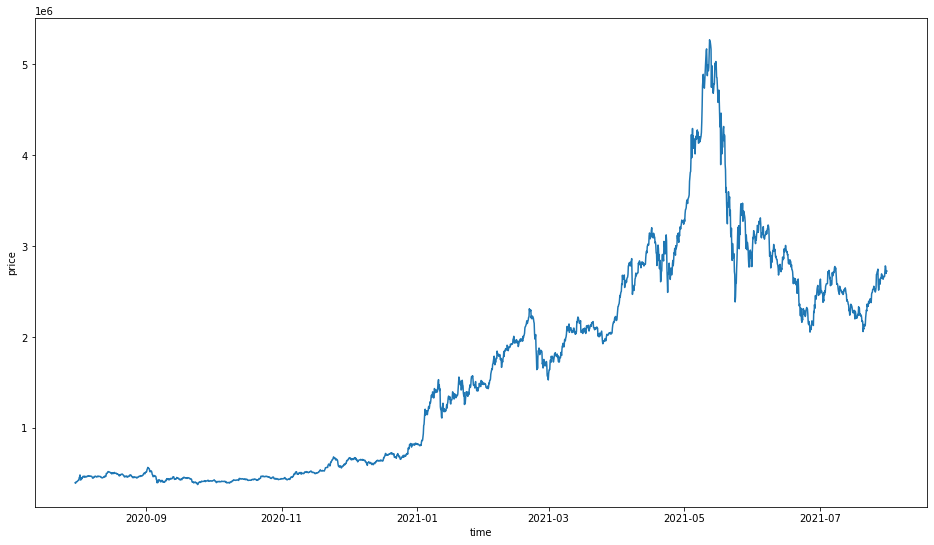

In [473]:
# 그래프 확인
plt.figure(figsize=(16,9))
sns.lineplot(y=data['close'], x=data.index)
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [474]:
data.reset_index(inplace=True)

In [475]:
data, acc=accuracy(data, 'close', 'close', True)

In [476]:
acc

54.4

In [477]:
data=data[1:]
data.reset_index(drop=True, inplace=True)

In [478]:
data

,index,open,high,low,close,volume,value,check
0,2020-07-31 09:00:00,394750.0,397200.0,388950.0,389000.0,18645.082020,7.326247e+09,0.0
1,2020-07-31 13:00:00,389000.0,399500.0,388850.0,397700.0,14881.001399,5.893566e+09,1.0
2,2020-07-31 17:00:00,397700.0,411000.0,396950.0,406700.0,29249.649668,1.180852e+10,1.0
3,2020-07-31 21:00:00,406700.0,410900.0,402100.0,407900.0,20448.543303,8.329156e+09,1.0
4,2020-08-01 01:00:00,407900.0,409750.0,404100.0,406500.0,8259.528069,3.363334e+09,0.0
...,...,...,...,...,...,...,...,...
2184,2021-07-30 09:00:00,2731000.0,2815000.0,2713000.0,2782000.0,24558.787897,6.814932e+10,1.0
2185,2021-07-30 13:00:00,2780000.0,2789000.0,2750000.0,2772000.0,13238.389354,3.671285e+10,0.0
2186,2021-07-30 17:00:00,2772000.0,2775000.0,2676000.0,2699000.0,29621.885813,8.026825e+10,0.0
2187,2021-07-30 21:00:00,2699000.0,2735000.0,2696000.0,2725000.0,11533.606005,3.132228e+10,1.0


In [440]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [479]:
#scaler=StandardScaler()
scaler=MinMaxScaler()
df_scaled=scaler.fit_transform(data[['open', 'close', 'volume', 'value','check']])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns=['open', 'close', 'volume', 'value', 'check']
df_scaled

,open,close,volume,value,check
0,0.004084,0.002799,0.039422,0.005538,0.0
1,0.002910,0.004576,0.031248,0.004423,1.0
2,0.004686,0.006415,0.062451,0.009025,1.0
3,0.006524,0.006660,0.043339,0.006318,1.0
4,0.006769,0.006374,0.016869,0.002455,0.0
...,...,...,...,...,...
2184,0.481137,0.491695,0.052264,0.052855,1.0
2185,0.491143,0.489652,0.027681,0.028399,0.0
2186,0.489509,0.474738,0.063259,0.062283,0.0
2187,0.474603,0.480050,0.023979,0.024205,1.0


In [480]:
size=200
train=df_scaled[:-size]
test=df_scaled[-size:]

In [481]:
def make_dataset(data, label, window_size=14): # 이전 20일 기간으로 다음날 예측하기
    feature_lst=[]
    label_lst=[]
    for i in range(len(data)-window_size):
        feature_lst.append(np.array(data.iloc[i:i+window_size]))
        label_lst.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_lst), np.array(label_lst)

In [511]:
train_feature=train[['close', 'volume', 'value']]  # 상관관계 적은 volume, value 가져옴
train_label=train[['check']]
train_feature, train_label = make_dataset(train_feature, train_label)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

((1580, 14, 3), (395, 14, 3), (1580, 1), (395, 1))

In [512]:
test_feature, test_label = make_dataset(test[['close', 'volume', 'value']], test[['check']])
(test_feature.shape, test_label.shape)

((186, 14, 3), (186, 1))

In [528]:
model = Sequential()
model.add(Dense(128, input_shape=(train_feature.shape[1], train_feature.shape[2]), activation='sigmoid'))
model.add(Dense(1, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 14, 128)           512       
_________________________________________________________________
dense_72 (Dense)             (None, 14, 1)             129       
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


In [510]:
model = Sequential()
model.add(LSTM(128, input_shape=(train_feature.shape[1], train_feature.shape[2]), activation='relu', return_sequences=False))
model.add(Dense(16))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 128)               67584     
_________________________________________________________________
dense_64 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_65 (Dense)             (None, 3)                 51        
Total params: 69,699
Trainable params: 69,699
Non-trainable params: 0
_________________________________________________________________


In [529]:
early_stop=EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(x_train, y_train, epochs=100, batch_size=1, 
                    validation_data=(x_valid, y_valid), callbacks=[early_stop])

Epoch 1/100
1580/1580 [==============================] - 1s 740us/step - loss: 7.0358 - accuracy: 0.5386 - val_loss: 6.6788 - val_accuracy: 0.5620
Epoch 2/100
1580/1580 [==============================] - 1s 657us/step - loss: 7.0358 - accuracy: 0.5386 - val_loss: 6.6788 - val_accuracy: 0.5620
Epoch 3/100
1580/1580 [==============================] - 1s 694us/step - loss: 7.0358 - accuracy: 0.5386 - val_loss: 6.6788 - val_accuracy: 0.5620
Epoch 4/100
1580/1580 [==============================] - 1s 653us/step - loss: 7.0358 - accuracy: 0.5386 - val_loss: 6.6788 - val_accuracy: 0.5620
Epoch 5/100
1580/1580 [==============================] - 1s 668us/step - loss: 7.0358 - accuracy: 0.5386 - val_loss: 6.6788 - val_accuracy: 0.5620
Epoch 6/100
1580/1580 [==============================] - 1s 717us/step - loss: 7.0358 - accuracy: 0.5386 - val_loss: 6.6788 - val_accuracy: 0.5620


In [530]:
pred=model.predict(test_feature)

In [527]:
test_label[4]

array([0.])

In [532]:
pred[0]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

ValueError: x and y can be no greater than 2-D, but have shapes (186,) and (186, 14, 1)

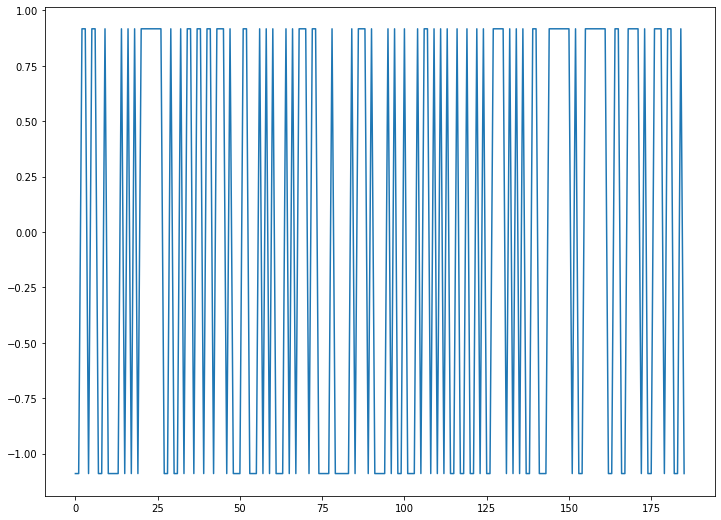

In [459]:
#시각화로 예측 확인
plt.figure(figsize=(12,9))
plt.plot(test_label, label='test')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [464]:
def accuracy(data, price, pred_price, num=False):
    data['check']=0.0
    data.loc[0,'check']=0.0
    for i in range(1,len(data)):
        if data.loc[i-1,price]<=data.loc[i,price] and data.loc[i-1, pred_price]<=data.loc[i, pred_price]:
            data.loc[i,'check']=1.0
        elif data.loc[i-1,price]>data.loc[i,price] and data.loc[i-1, pred_price]>data.loc[i, pred_price]:
            if num:
                data.loc[i,'check']=0.0
            else:
                data.loc[i,'check']=1.0
        else:
            data.loc[i,'check']=0.0

    acc=np.round(len(data.query('check==1.0'))/(len(data)-1)*100, 1)
    return data, acc

In [503]:
test_label[:]

array([[0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],

In [509]:
pred[10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [502]:
pred_df=pd.DataFrame(pred)

ValueError: Must pass 2-d input. shape=(186, 14, 1)

In [499]:
test_df=pd.DataFrame(test_label[:])
pred_df=pd.DataFrame(pred.reshape(1,-1))
test_df.columns=['price']
pred_df.columns=['pred_price']
total_df=pd.concat([test_df,pred_df], axis=1)

ValueError: Length mismatch: Expected axis has 2604 elements, new values have 1 elements

In [413]:
df, acc=accuracy(total_df, 'price', 'pred_price')
acc

46.6

In [414]:
df

,price,pred_price,check
0,0.658438,0.652093,0.0
1,0.648064,0.657804,0.0
2,0.650658,0.654374,0.0
3,0.641149,0.653219,1.0
4,0.632504,0.646602,1.0
...,...,...,...
189,0.940258,0.936099,1.0
190,0.948902,0.937197,1.0
191,0.937664,0.947771,0.0
192,0.949767,0.942275,0.0
